In [8]:
import gym 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm.notebook import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical

In [9]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from multiprocessing_env import SubprocVecEnv

## PPO (Proximal policy approximation)

In [10]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
                
    def forward(self, x):
        value = self.critic(x)
        out    = self.actor(x)
        out = F.softmax(out, dim=-1)
        dist =  Categorical(out)
        return value, dist

In [17]:
class Reward_counter() :
    def __init__(self, n_workers) :
        self.n_workers = n_workers
        self.reset()
        
    def reset(self) :
        self.reward_log = [[] for i in range(self.n_workers)]
        self.acc_reward = np.zeros(self.n_workers)
        
    def update(self, rewards, dones) :
        for i, (r, done) in enumerate(zip(rewards, dones)) :
            self.update_worker(i, r, done)
            
    def update_worker(self, i, reward, done) :
        self.acc_reward[i] += reward
        if done : 
            self.reward_log[i].append(self.acc_reward[i])
            self.acc_reward[i] = 0
        
    def plot_results(self, conv=100) :
        plt.title('Reward avg per workers over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Reward avg')
        for i in range(self.n_workers) :
            rew_worker = rewards_avg = np.convolve(self.reward_log[i], np.ones((conv,))/conv, mode='valid')
            plt.plot(rew_worker, label=f'worker {i}')
        plt.show()

In [18]:
def batch_iter(advantage, ob_states, actions, log_probs, returns, batch_size=4) :
    for i in range(n_steps // batch_size) :
        idxs = np.random.permutation(range(n_steps))[:batch_size]
        yield advantage[idxs], ob_states[idxs], actions[idxs], log_probs[idxs], returns[idxs], idxs

In [19]:
def ppo_train(actor_critic, enviorements, n_workers, n_episodes = 500, lr = 1e-3, 
              gamma = 0.990, n_steps = 40, eps = 0.2, batch_size = 4, n_epochs = 4,
              reward_counter=None, show_result=10, device='cpu') :
    
    opt = Adam(actor_critic.parameters(), lr=lr)
    reward_counter = Reward_counter(n_workers) if reward_counter is None else reward_counter
    
    for i in tqdm_notebook(range(n_episodes)) :

        rewards = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        mask = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        log_probs = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        values = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        actions = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        ob_states = torch.zeros((n_steps, n_workers, 4), dtype=torch.float).to(device)


        if i == 0 :
            observations = torch.tensor(enviorements.reset(), dtype=torch.float, device=device)

        step = 0
        while step < n_steps :

            vals, dist = actor_critic(observations)
            
            ob_states[step] = observations
            values[step] = vals.view(-1)

            #choose action
            act = dist.sample()
            log_probs[step] = dist.log_prob(act)
            actions[step] = act

            obs, r, dones, _ = enviorements.step(act.numpy())
            mask[step] = torch.tensor(1-dones).to(device)
            rewards[step] = torch.from_numpy(r)

            observations = torch.tensor(obs, dtype=torch.float).to(device)

            reward_counter.update(r, dones)
            step+=1                   

        #discounted returns calculation (with bootstraping)
        returns = torch.zeros((n_steps, n_workers), dtype=torch.float).to(device)
        with torch.no_grad() :
            q_val, _ = actor_critic(observations)
        q_val = q_val.view(-1).detach()
        for i in reversed(range(n_steps)) :
            q_val = rewards[i] + gamma * q_val * (mask[i])
            returns[i] = q_val
        advantage = (returns - values).detach()
        
        #optimization
        for epoch in range(n_epochs) :
            a = 0
            for adv_b, state_b, action_b, l_probs_b, returns_b, idxs in batch_iter(advantage, ob_states, actions, log_probs, returns.detach(), batch_size=batch_size) :

                vals, dist = actor_critic(state_b)

                new_actor_probs = dist.log_prob(action_b)

                #probability ration and clipped prob ration
                r = torch.exp((new_actor_probs) - (l_probs_b.detach()))
                clipped_r = torch.clamp(r, 1-eps, 1+eps)
                adv = returns_b.view(batch_size, n_workers, -1) - vals

                #critic loss
                critic_loss = adv.pow(2).mean()

                #actor loss
                clipped_loss = clipped_r * adv_b.detach()
                loss_ = r * adv_b.detach()
                actor_loss = -torch.min(clipped_loss, loss_).mean()

                opt.zero_grad()
                loss = 0.5 * (critic_loss + actor_loss)
                loss.backward()
                opt.step()

    if show_result is not None :
        reward_counter.plot_results(conv=show_result)
        
    return actor_critic, reward_counter
    

## Cartpole-v0 test

In [20]:
num_envs = 16
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

In [21]:
dev = torch.device('cpu')
hidden_size = 20
actor_critic = ActorCritic(4, 2, hidden_size).to(dev)

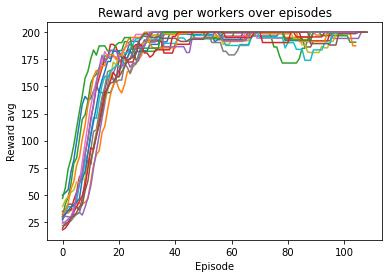

In [22]:
actor_critic, reward_counter = ppo_train(actor_critic, envs, 16)